In [ ]:
!pip install -q tensorflow-recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import register_keras_serializable
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('Data Transaksi FIX.csv')

In [ ]:
data.head()

,Id_member,Tanggal,Deskripsi_barang,Kategori
0,1808,2015-07-21,apel,Buah-buahan
1,2552,2015-05-01,susu sapi,Makanan dan Minuman
2,2300,2015-09-19,nanas,Buah-buahan
3,1187,2015-12-12,bayam,Sayuran
4,3037,2015-01-02,susu sapi,Makanan dan Minuman


In [ ]:
#Using pandas way, Series.value_counts()
df1 = data['Deskripsi_barang'].value_counts()
df1 = data.Deskripsi_barang.value_counts

# Using groupby() & count()
df1 = data.groupby('Deskripsi_barang').count()

# Add frequecy count as new column to DataFrame
data['Transaksi'] = data.groupby('Deskripsi_barang')['Deskripsi_barang'].transform('count')

# Mengubah skala freq_count menjadi skala 0-1 (normalisasi mean)
min_count = data['Transaksi'].min()
max_count = data['Transaksi'].max()
data['Skala'] = (data['Transaksi'] - min_count) / (max_count - min_count)

print(data)

       Id_member     Tanggal Deskripsi_barang             Kategori  Transaksi  \
0           1808  2015-07-21             apel          Buah-buahan       1032   
1           2552  2015-05-01        susu sapi  Makanan dan Minuman       2502   
2           2300  2015-09-19            nanas          Buah-buahan        744   
3           1187  2015-12-12            bayam              Sayuran       1898   
4           3037  2015-01-02        susu sapi  Makanan dan Minuman       2502   
...          ...         ...              ...                  ...        ...   
38760       4471  2014-08-10             keju  Makanan dan Minuman        258   
38761       2022  2014-02-23           permen  Makanan dan Minuman        219   
38762       1097  2014-04-16          kue bar  Makanan dan Minuman         93   
38763       1510  2014-03-12            udang           Ikan Segar        518   
38764       1521  2014-12-26            belut           Ikan Segar        177   

          Skala  
0      0.

In [ ]:
users = data['Id_member'].unique()
items = data['Deskripsi_barang'].unique()

user_indices = {user: index for index, user in enumerate(users)}
item_indices = {item: index for index, item in enumerate(items)}

num_users = len(users)
num_items = len(items)
transaction_matrix = np.zeros((num_users, num_items))
for index, row in data.iterrows():
    user = row['Id_member']
    item = row['Deskripsi_barang']
    Transaksi = row['Skala']
    user_index = user_indices[user]
    item_index = item_indices[item]
    transaction_matrix[user_index, item_index] = Transaksi

In [ ]:
train_matrix, val_matrix = train_test_split(transaction_matrix, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_matrix, train_matrix))
train_dataset = train_dataset.batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_matrix, val_matrix))
val_dataset = val_dataset.batch(64)

In [ ]:
class RecommenderModel(tfrs.Model):
    def __init__(self):
        super(RecommenderModel, self).__init__()
        self.user_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64)
        ])
        self.item_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64)
        ])
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(1)
        ])
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def compute_loss(self, inputs, training=False):
        user_embeddings = self.user_model(inputs[0])
        item_embeddings = self.item_model(inputs[1])
        ratings = self.rating_model(tf.concat([user_embeddings, item_embeddings], axis=1))
        return self.task(labels=inputs[1], predictions=ratings)

    def call(self, inputs):
        return self.compute_loss(inputs)

In [ ]:
model = RecommenderModel()

sample_batch = next(iter(train_dataset))
model(sample_batch)

model.summary()

Model: "recommender_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 64)                  72640     
                                                                 
 sequential_1 (Sequential)   (64, 64)                  72640     
                                                                 
 sequential_2 (Sequential)   (64, 1)                   129       
                                                                 
 ranking (Ranking)           multiple                  0         
                                                                 
Total params: 145,409
Trainable params: 145,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
49/49 [==============================] - 2s 11ms/step - root_mean_squared_error: 0.1174 - loss: 0.0137 - regularization_loss: 0.0000e+00 - total_loss: 0.0137 - val_root_mean_squared_error: 0.1128 - val_loss: 0.0115 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0115
Epoch 2/10
49/49 [==============================] - 0s 7ms/step - root_mean_squared_error: 0.1131 - loss: 0.0128 - regularization_loss: 0.0000e+00 - total_loss: 0.0128 - val_root_mean_squared_error: 0.1126 - val_loss: 0.0115 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0115
Epoch 3/10
49/49 [==============================] - 0s 7ms/step - root_mean_squared_error: 0.1129 - loss: 0.0127 - regularization_loss: 0.0000e+00 - total_loss: 0.0127 - val_root_mean_squared_error: 0.1125 - val_loss: 0.0115 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0115
Epoch 4/10
49/49 [==============================] - 0s 7ms/step - root_mean_squared_error: 0.1128 - loss: 0.0127 - regularization_loss:

In [ ]:
model.evaluate(val_dataset)

13/13 [==============================] - 0s 3ms/step - root_mean_squared_error: 0.1124 - loss: 0.0125 - regularization_loss: 0.0000e+00 - total_loss: 0.0125


[0.11238101124763489, 0.011463710106909275, 0, 0.011463710106909275]

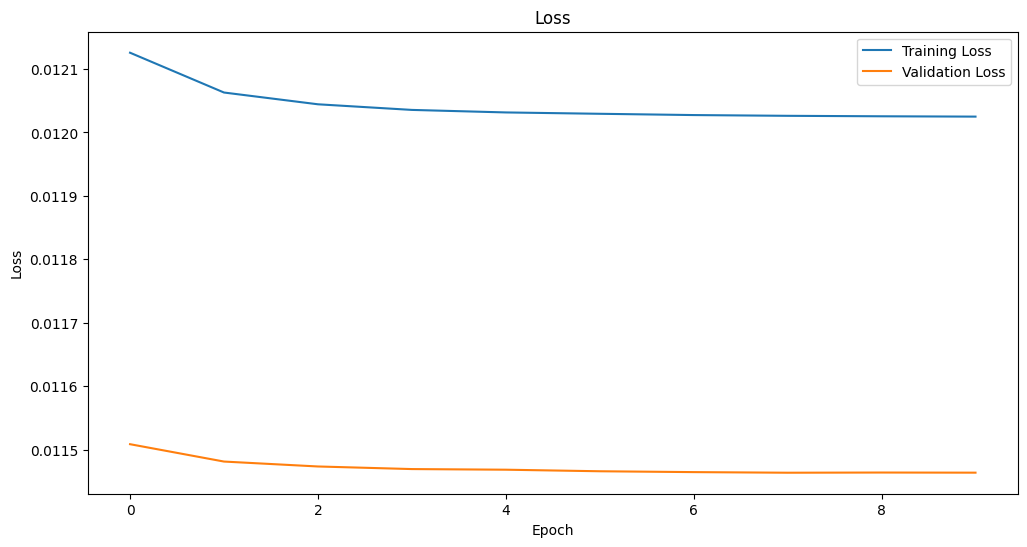

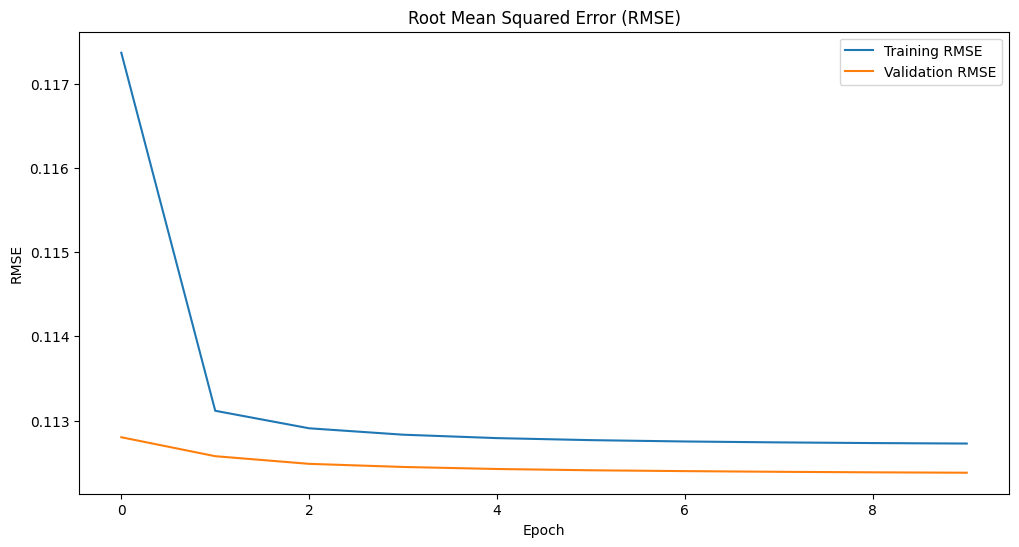

In [ ]:
# Mengambil loss dan RMSE dari history
loss = history.history['loss']
val_loss = history.history['val_loss']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Membuat grafik loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Membuat grafik RMSE
plt.figure(figsize=(12, 6))
plt.plot(rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Generate recommendations
target_user = 1020
user_index = user_indices[target_user]
user_input = tf.expand_dims(train_matrix[user_index], axis=0)
recommendations = model.user_model(user_input)

# Get the top recommendations with confidence scores
top_items_indices = np.argsort(recommendations.numpy()[0])[::-1][:5]
top_items = [items[i] for i in top_items_indices]
confidence_scores = recommendations.numpy()[0][top_items_indices]

print(f"Top 5 recommendations for user ", target_user)
for i, (item, score) in enumerate(zip(top_items, confidence_scores)):
    print(f"Recommendation {i+1}: {item} (Confidence Score: {score:.2f})")

Top 5 recommendations for user  1020
Recommendation 1: ikan sarden (Confidence Score: 0.06)
Recommendation 2: keju (Confidence Score: 0.05)
Recommendation 3: gurita (Confidence Score: 0.04)
Recommendation 4: sosis (Confidence Score: 0.04)
Recommendation 5: gula (Confidence Score: 0.04)


In [ ]:
import pickle
pickle.dump(model,open('model.pkl','wb'))
# model.save('my_model', save_format='tf')
tf.keras.models.save_model(model.user_model, 'output_model.h5', save_format='h5')

In [ ]:

# # Load the SavedModel
# saved_model_dir = '/content/my_model'
# loaded_model = tf.saved_model.load(saved_model_dir)

# # Convert the model to TensorFlow Lite format with TF Select
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter.optimization = [tf.lite.Optimize.DEFAULT]
# converter.experimental_new_converter = True
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model to a file
# with open("model.tflite", "wb") as f:
#     f.write(tflite_model)

# import tensorflow as tf

# # Assuming 'model' is your trained model
# # Convert the model to TFLite format with TF Select enabled
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open('recommendation_model.tflite', 'wb') as f:
#     f.write(tflite_model)
